In [ ]:
import ssl
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch_optimizer
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = './data/archive (2)/images/Images'

print(f"Устройство: {DEVICE}")
print(f"Путь к данным: {DATA_DIR}")

Устройство: cuda
Путь к данным: ./data/archive (2)/images/Images


In [ ]:
def get_loaders(is_pretrained, batch_size=64):

    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    if is_pretrained:
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            norm
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            norm
        ])

    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm
    ])

    if not os.path.exists(DATA_DIR):
        raise FileNotFoundError(f"Папка {DATA_DIR} не найдена!")

    full_dataset = datasets.ImageFolder(root=DATA_DIR)
    total_size = len(full_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_idx, val_idx, test_idx = random_split(
        list(range(total_size)), [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_ds = torch.utils.data.Subset(datasets.ImageFolder(DATA_DIR, transform=train_transform), train_idx.indices)
    val_ds = torch.utils.data.Subset(datasets.ImageFolder(DATA_DIR, transform=val_transform), val_idx.indices)
    test_ds = torch.utils.data.Subset(datasets.ImageFolder(DATA_DIR, transform=val_transform), test_idx.indices)

    return {
        'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        'val': DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
        'test': DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    }

def get_model(pretrained=True):
    weights = models.VGG11_Weights.DEFAULT if pretrained else None
    model = models.vgg11(weights=weights)

    if not pretrained:
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 120)
    return model.to(DEVICE)

def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'{title} Loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['f1'], label='Val F1', color='green')
    plt.title(f'{title} F1 Score')
    plt.grid(True)
    plt.show()

Запуск: Pretrained + LARS
Epoch 01/10 | Loss: 4.7938 | Val F1: 0.0428
Epoch 02/10 | Loss: 4.2988 | Val F1: 0.2998
Epoch 03/10 | Loss: 3.3894 | Val F1: 0.4942
Epoch 04/10 | Loss: 2.8252 | Val F1: 0.6038
Epoch 05/10 | Loss: 2.5297 | Val F1: 0.6397
Epoch 06/10 | Loss: 2.3566 | Val F1: 0.6670
Epoch 07/10 | Loss: 2.2125 | Val F1: 0.6715
Epoch 08/10 | Loss: 2.1146 | Val F1: 0.6896
Epoch 09/10 | Loss: 2.0288 | Val F1: 0.7059
Epoch 10/10 | Loss: 1.9897 | Val F1: 0.7000


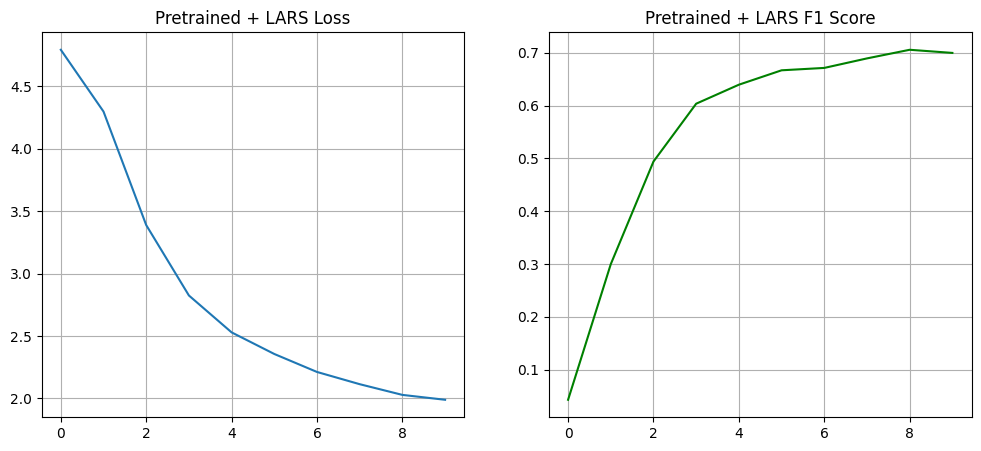

In [ ]:
EXP_NAME = "Pretrained + LARS"
EPOCHS = 10
LR = 0.01
WD = 1e-4

print(f"Запуск: {EXP_NAME}")
loaders = get_loaders(is_pretrained=True)
model = get_model(pretrained=True)
criterion = nn.CrossEntropyLoss()

optimizer = torch_optimizer.LARS(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(loaders['train']), epochs=EPOCHS)

history = {'loss': [], 'f1': []}

for epoch in range(EPOCHS):
    model.train()
    r_loss = 0
    for img, lbl in loaders['train']:
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(img), lbl)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        scheduler.step()
        r_loss += loss.item() * img.size(0)

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for img, lbl in loaders['val']:
            img, lbl = img.to(DEVICE), lbl.to(DEVICE)
            _, p = torch.max(model(img), 1)
            preds.extend(p.cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    epoch_loss = r_loss / len(loaders['train'].dataset)
    epoch_f1 = f1_score(targets, preds, average='macro', zero_division=0)
    history['loss'].append(epoch_loss)
    history['f1'].append(epoch_f1)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val F1: {epoch_f1:.4f}")

plot_history(history, EXP_NAME)

Запуск: Pretrained + Adam
Epoch 01/10 | Loss: 4.5375 | Val F1: 0.3273
Epoch 02/10 | Loss: 2.6901 | Val F1: 0.6177
Epoch 03/10 | Loss: 2.1157 | Val F1: 0.6349
Epoch 04/10 | Loss: 1.8833 | Val F1: 0.6436
Epoch 05/10 | Loss: 1.6958 | Val F1: 0.6991
Epoch 06/10 | Loss: 1.5446 | Val F1: 0.7083
Epoch 07/10 | Loss: 1.3818 | Val F1: 0.7227
Epoch 08/10 | Loss: 1.2463 | Val F1: 0.7430
Epoch 09/10 | Loss: 1.1682 | Val F1: 0.7573
Epoch 10/10 | Loss: 1.1162 | Val F1: 0.7581


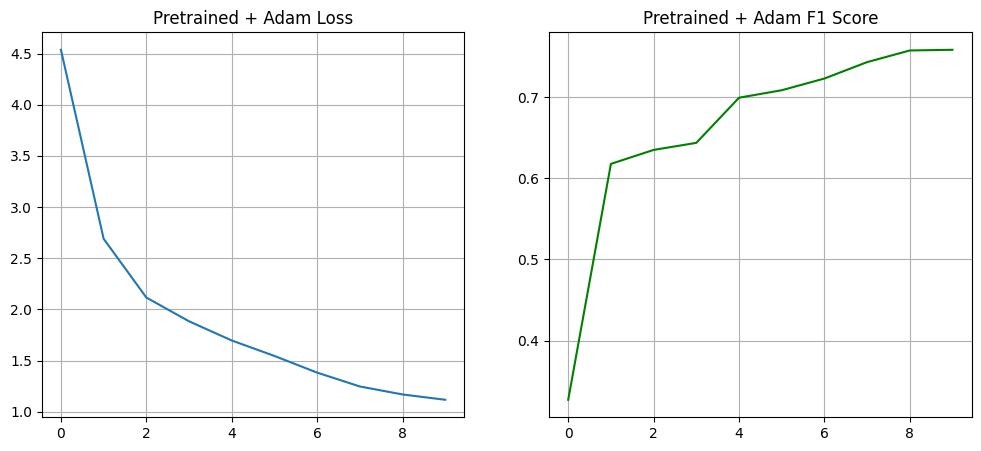

In [ ]:
EXP_NAME = "Pretrained + Adam"
EPOCHS = 10
LR = 1e-4
WD = 1e-4

print(f"Запуск: {EXP_NAME}")
loaders = get_loaders(is_pretrained=True)
model = get_model(pretrained=True)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(loaders['train']), epochs=EPOCHS)

history = {'loss': [], 'f1': []}

for epoch in range(EPOCHS):
    model.train()
    r_loss = 0
    for img, lbl in loaders['train']:
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(img), lbl)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        scheduler.step()
        r_loss += loss.item() * img.size(0)

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for img, lbl in loaders['val']:
            img, lbl = img.to(DEVICE), lbl.to(DEVICE)
            _, p = torch.max(model(img), 1)
            preds.extend(p.cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    epoch_loss = r_loss / len(loaders['train'].dataset)
    epoch_f1 = f1_score(targets, preds, average='macro', zero_division=0)
    history['loss'].append(epoch_loss)
    history['f1'].append(epoch_f1)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val F1: {epoch_f1:.4f}")

plot_history(history, EXP_NAME)

Запуск: Scratch + LARS (VGG11_BN) (С Batch Normalization)


Epoch 01/40 | Loss: 4.9553 | Val F1: 0.0043


Epoch 02/40 | Loss: 4.8640 | Val F1: 0.0056


Epoch 03/40 | Loss: 4.8158 | Val F1: 0.0061


Epoch 04/40 | Loss: 4.7737 | Val F1: 0.0065


Epoch 05/40 | Loss: 4.7269 | Val F1: 0.0128


Epoch 06/40 | Loss: 4.6619 | Val F1: 0.0157


Epoch 07/40 | Loss: 4.5850 | Val F1: 0.0150


Epoch 08/40 | Loss: 4.5041 | Val F1: 0.0239


Epoch 09/40 | Loss: 4.4421 | Val F1: 0.0306


Epoch 10/40 | Loss: 4.3784 | Val F1: 0.0316


Epoch 11/40 | Loss: 4.3168 | Val F1: 0.0395


Epoch 12/40 | Loss: 4.2510 | Val F1: 0.0477


Epoch 13/40 | Loss: 4.1906 | Val F1: 0.0595


Epoch 14/40 | Loss: 4.1241 | Val F1: 0.0538


Epoch 15/40 | Loss: 4.0690 | Val F1: 0.0638


Epoch 16/40 | Loss: 4.0185 | Val F1: 0.0748


Epoch 17/40 | Loss: 3.9667 | Val F1: 0.0814


Epoch 18/40 | Loss: 3.9201 | Val F1: 0.0922


Epoch 19/40 | Loss: 3.8602 | Val F1: 0.0956


Epoch 20/40 | Loss: 3.8298 | Val F1: 0.0893


Epoch 21/40 | Loss: 3.7803 | Val F1: 0.1009


Epoch 22/40 | Loss: 3.7450 | Val F1: 0.0987


Epoch 23/40 | Loss: 3.7041 | Val F1: 0.1123


Epoch 24/40 | Loss: 3.6630 | Val F1: 0.1274


Epoch 25/40 | Loss: 3.6278 | Val F1: 0.1210


Epoch 26/40 | Loss: 3.5866 | Val F1: 0.1315


Epoch 27/40 | Loss: 3.5530 | Val F1: 0.1317


Epoch 28/40 | Loss: 3.5211 | Val F1: 0.1336


Epoch 29/40 | Loss: 3.4907 | Val F1: 0.1486


Epoch 30/40 | Loss: 3.4475 | Val F1: 0.1485


Epoch 31/40 | Loss: 3.4412 | Val F1: 0.1601


Epoch 32/40 | Loss: 3.4079 | Val F1: 0.1530


Epoch 33/40 | Loss: 3.3854 | Val F1: 0.1674


Epoch 34/40 | Loss: 3.3575 | Val F1: 0.1634


Epoch 35/40 | Loss: 3.3269 | Val F1: 0.1669


Epoch 36/40 | Loss: 3.3181 | Val F1: 0.1720


Epoch 37/40 | Loss: 3.3008 | Val F1: 0.1736


Epoch 38/40 | Loss: 3.2912 | Val F1: 0.1712


Epoch 39/40 | Loss: 3.2885 | Val F1: 0.1699


Epoch 40/40 | Loss: 3.2820 | Val F1: 0.1721


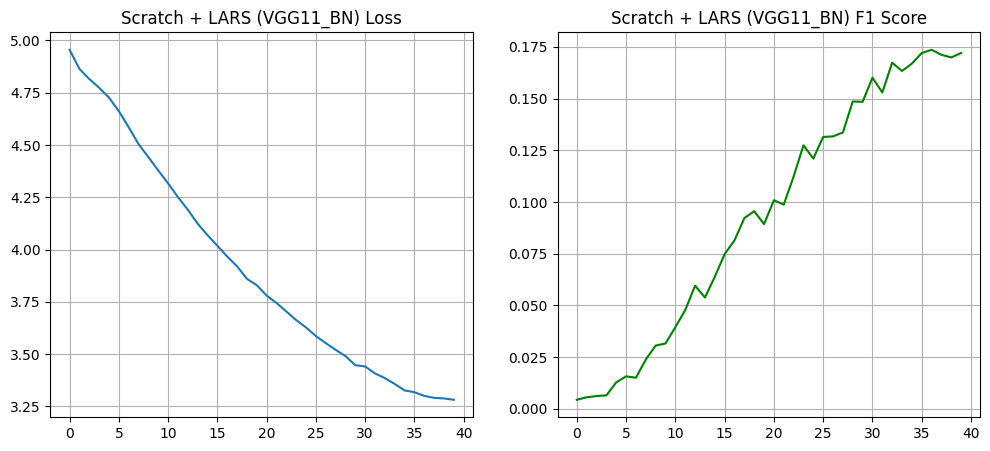

In [ ]:
EXP_NAME = "Scratch + LARS (VGG11_BN)"
EPOCHS = 40
LR = 0.1  
WD = 1e-4

print(f"Запуск: {EXP_NAME} (С Batch Normalization)")
loaders = get_loaders(is_pretrained=False)

def get_model_bn():
    model = models.vgg11_bn(weights=None)

    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 120)
    return model.to(DEVICE)

model = get_model_bn()
criterion = nn.CrossEntropyLoss()

optimizer = torch_optimizer.LARS(
    model.parameters(),
    lr=LR,
    momentum=0.9,
    weight_decay=WD,
    trust_coefficient=0.001
)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=len(loaders['train']),
    epochs=EPOCHS,
    pct_start=0.3
)

history = {'loss': [], 'f1': []}

for epoch in range(EPOCHS):
    model.train()
    r_loss = 0
    for img, lbl in tqdm(loaders['train'], desc=f"Ep {epoch+1}", leave=False):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(img), lbl)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        scheduler.step()
        r_loss += loss.item() * img.size(0)

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for img, lbl in loaders['val']:
            img, lbl = img.to(DEVICE), lbl.to(DEVICE)
            _, p = torch.max(model(img), 1)
            preds.extend(p.cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    epoch_loss = r_loss / len(loaders['train'].dataset)
    epoch_f1 = f1_score(targets, preds, average='macro', zero_division=0)
    history['loss'].append(epoch_loss)
    history['f1'].append(epoch_f1)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val F1: {epoch_f1:.4f}")

plot_history(history, EXP_NAME)

Запуск: Scratch + Adam (VGG11_BN) (С Batch Normalization)


Epoch 01/40 | Loss: 4.8719 | Val F1: 0.0087


Epoch 02/40 | Loss: 4.6037 | Val F1: 0.0153


Epoch 03/40 | Loss: 4.4307 | Val F1: 0.0258


Epoch 04/40 | Loss: 4.3107 | Val F1: 0.0209


Epoch 05/40 | Loss: 4.2563 | Val F1: 0.0287


Epoch 06/40 | Loss: 4.1871 | Val F1: 0.0407


Epoch 07/40 | Loss: 4.1060 | Val F1: 0.0321


Epoch 08/40 | Loss: 4.0216 | Val F1: 0.0501


Epoch 09/40 | Loss: 3.9467 | Val F1: 0.0595


Epoch 10/40 | Loss: 3.8588 | Val F1: 0.0436


Epoch 11/40 | Loss: 3.7552 | Val F1: 0.0852


Epoch 12/40 | Loss: 3.6909 | Val F1: 0.0833


Epoch 13/40 | Loss: 3.5842 | Val F1: 0.0810


Epoch 14/40 | Loss: 3.5319 | Val F1: 0.1118


Epoch 15/40 | Loss: 3.4091 | Val F1: 0.1217


Epoch 16/40 | Loss: 3.3515 | Val F1: 0.1344


Epoch 17/40 | Loss: 3.2837 | Val F1: 0.1508


Epoch 18/40 | Loss: 3.2004 | Val F1: 0.1757


Epoch 19/40 | Loss: 3.2050 | Val F1: 0.1741


Epoch 20/40 | Loss: 2.9732 | Val F1: 0.2363


Epoch 21/40 | Loss: 2.8872 | Val F1: 0.1973


Epoch 22/40 | Loss: 2.8858 | Val F1: 0.2735


Epoch 23/40 | Loss: 2.6050 | Val F1: 0.3038


Epoch 24/40 | Loss: 2.4780 | Val F1: 0.2913


Epoch 25/40 | Loss: 2.3501 | Val F1: 0.3637


Epoch 26/40 | Loss: 2.2336 | Val F1: 0.3873


Epoch 27/40 | Loss: 2.1107 | Val F1: 0.3733


Epoch 28/40 | Loss: 1.9894 | Val F1: 0.4188


Epoch 29/40 | Loss: 1.8792 | Val F1: 0.4436


Epoch 30/40 | Loss: 1.7646 | Val F1: 0.4594


Epoch 31/40 | Loss: 1.6606 | Val F1: 0.4806


Epoch 32/40 | Loss: 1.5756 | Val F1: 0.4956


Epoch 33/40 | Loss: 1.4677 | Val F1: 0.4965


Epoch 34/40 | Loss: 1.3699 | Val F1: 0.5203


Epoch 35/40 | Loss: 1.2782 | Val F1: 0.5221


Epoch 36/40 | Loss: 1.2183 | Val F1: 0.5315


Epoch 37/40 | Loss: 1.1788 | Val F1: 0.5404


Epoch 38/40 | Loss: 1.1396 | Val F1: 0.5443


Epoch 39/40 | Loss: 1.0946 | Val F1: 0.5430


Epoch 40/40 | Loss: 1.0814 | Val F1: 0.5427


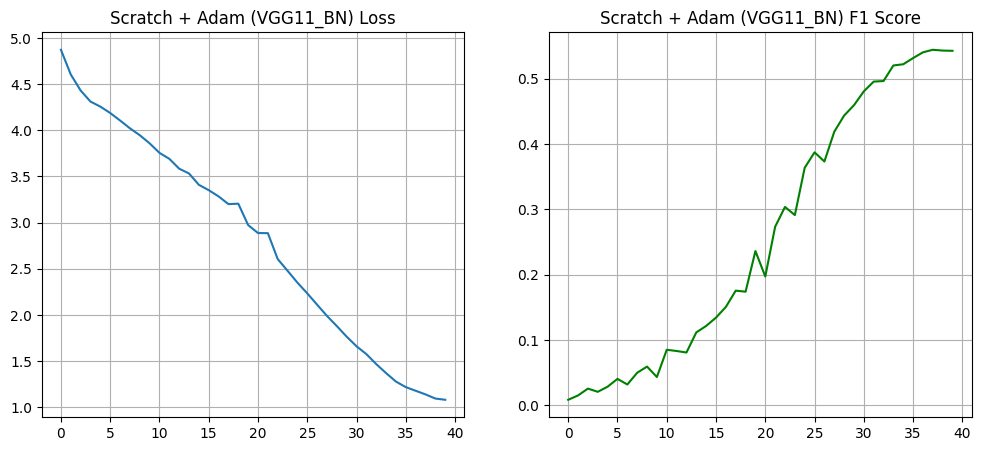

In [ ]:
EXP_NAME = "Scratch + Adam (VGG11_BN)"
EPOCHS = 40
LR = 1e-3 
WD = 1e-4

print(f"Запуск: {EXP_NAME} (С Batch Normalization)")

loaders = get_loaders(is_pretrained=False)
model = get_model_bn() 
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(loaders['train']), epochs=EPOCHS)

history = {'loss': [], 'f1': []}

for epoch in range(EPOCHS):
    model.train()
    r_loss = 0
    for img, lbl in tqdm(loaders['train'], desc=f"Ep {epoch+1}", leave=False):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(img), lbl)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        scheduler.step()
        r_loss += loss.item() * img.size(0)

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for img, lbl in loaders['val']:
            img, lbl = img.to(DEVICE), lbl.to(DEVICE)
            _, p = torch.max(model(img), 1)
            preds.extend(p.cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    epoch_loss = r_loss / len(loaders['train'].dataset)
    epoch_f1 = f1_score(targets, preds, average='macro', zero_division=0)
    history['loss'].append(epoch_loss)
    history['f1'].append(epoch_f1)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val F1: {epoch_f1:.4f}")

plot_history(history, EXP_NAME)